<a href="https://colab.research.google.com/github/JulioCesarMS/Finance/blob/main/PortfolioAnalysis_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> **Portfolio analysis**

In [ ]:
!pip install yfinance
!pip install mplcyberpunk

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
# gráficos interactivos
import plotly.graph_objects as go
import plotly.express as px
# módulos optimización
import scipy.optimize as optimize
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas
# we scrapping
import bs4 as bs
import requests
import lxml
from functools import reduce
# matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
#sns.set()
plt.style.use("cyberpunk")

# **Información del indice IPC**

In [ ]:
resp = requests.get('https://en.wikipedia.org/wiki/Indice_de_Precios_y_Cotizaciones')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [ ]:
ipc_table = pd.read_html(str(table))[0]
ipc_table

Name       Symbol  \
0                    Arca Continental           AC   
1                                ALFA       ALFA A   
2                               Alsea        ALSEA   
3                       América Móvil        AMX L   
4     Grupo Aeroportuario del Sureste       ASUR B   
5                     Banco del Bajío     BBAJIO O   
6                         Grupo Bimbo      BIMBO A   
7           Bolsa Mexicana de Valores      BOLSA A   
8                               Cemex    CEMEX CPO   
9                               Becle       CUERVO   
10                      Grupo Elektra      ELEKTRA   
11                              FEMSA    FEMSA UBD   
12   Grupo Aeroportuario del Pacífico        GAP B   
13                        Grupo Carso    GCARSO A1   
14        Grupo Cementos de Chihuahua          GCC   
15                            Inbursa    GFINBUR O   
16                            Banorte    GFNORTE O   
17                       Grupo México    GMEXICO B   
18                              Gruma      GRUMA B   
19           Kimberly-Clark de México     KIMBER A   
20                    Coca-Cola FEMSA        KOF L   
21          Genomma Lab Internacional        LAB B   
22                          Liverpool  LIVEPOL C-1   
23                          Megacable     MEGA CPO   
24   Grupo Aeroportuario Centro Norte        OMA B   
25                              Orbia        ORBIA   
26                            Peñoles      PE&OLES   
27                             Pinfra       PINFRA   
28                           Quálitas            Q   
29                           Regional          R A   
30                          Telesites    SITES B-1   
31                           Televisa  TLEVISA CPO   
32     Corporación Inmobiliaria Vesta        VESTA   
33                            Volaris      VOLAR A   
34  Walmart de México y Centroamérica       WALMEX   

                        Sector                              Industry  \
0             Consumer Staples                             Beverages   
1                  Industrials              Industrial Conglomerates   
2       Consumer Discretionary         Hotels, Restaurants & Leisure   
3   Telecommunication Services           Wireless Telecommunications   
4                  Industrials         Transportation Infrastructure   
5                          NaN                                   NaN   
6             Consumer Staples                         Food Products   
7                   Financials        Diversified Financial Services   
8                    Materials                Construction Materials   
9                          NaN                                   NaN   
10                  Financials                                 Banks   
11            Consumer Staples                             Beverages   
12                 Industrials         Transportation Infrastructure   
13                 Industrials              Industrial Conglomerates   
14                   Materials                Construction Materials   
15                   Financial                                 Banks   
16                   Financial                                 Banks   
17                   Materials                       Metals & Mining   
18            Consumer Staples                         Food Products   
19            Consumer Staples                    Household Products   
20            Consumer Staples                             Beverages   
21                  Healthcare                       Pharmaceuticals   
22      Consumer Discretionary                      Multiline Retail   
23      Consumer Discretionary                                 Media   
24                 Industrials         Transportation Infrastructure   
25                   Materials                             Chemicals   
26                   Materials                       Metals & Mining   
27                 Industrials            Construction & Engineering   


In [ ]:
tickers_ipc = list(ipc_table.sort_values('Sector')['Symbol'])
sectors_ipc = list(ipc_table.sort_values('Sector')['Sector'])

In [ ]:
unique, counts = np.unique(sectors_ipc, return_counts=True)
dict(zip(unique, counts))

{'Consumer Discretionary': 4,
 'Consumer Staples': 7,
 'Financial': 3,
 'Financials': 4,
 'Healthcare': 1,
 'Industrials': 7,
 'Materials': 5,
 'Telecommunication Services': 1,
 'nan': 3}

In [ ]:
# extraemos símbolos
stocks = []
for row in ipc_table.Symbol:
  symbol = row.strip().replace(" ", "").replace("-", "").replace("&", "")  + '.MX'
  stocks.append(symbol)
print(stocks)

['AC.MX', 'ALFAA.MX', 'ALSEA.MX', 'AMXL.MX', 'ASURB.MX', 'BBAJIOO.MX', 'BIMBOA.MX', 'BOLSAA.MX', 'CEMEXCPO.MX', 'CUERVO.MX', 'ELEKTRA.MX', 'FEMSAUBD.MX', 'GAPB.MX', 'GCARSOA1.MX', 'GCC.MX', 'GFINBURO.MX', 'GFNORTEO.MX', 'GMEXICOB.MX', 'GRUMAB.MX', 'KIMBERA.MX', 'KOFL.MX', 'LABB.MX', 'LIVEPOLC1.MX', 'MEGACPO.MX', 'OMAB.MX', 'ORBIA.MX', 'PEOLES.MX', 'PINFRA.MX', 'Q.MX', 'RA.MX', 'SITESB1.MX', 'TLEVISACPO.MX', 'VESTA.MX', 'VOLARA.MX', 'WALMEX.MX']


In [ ]:
def download_data(stocks, start_date, end_date):

  stock_data = {}
  for stock in stocks:
    symbol = yf.Ticker(stock)
    stock_data[stock] = symbol.history(start=start_date, end=end_date)['Close']

  df = pd.DataFrame(stock_data)
  return df

## **Download data**

lista de activos:


'IENOVA.MX', 'GENTERA.MX', 'AC.MX', 'MEGACPO.MX', 'AMXL.MX', 'ALPEKA.MX', 'CUERVO.MX', 'LABB.MX', 'GMEXICOB.MX', 'GRUMAB.MX', 'GFNORTEO.MX', 
'FEMSAUBD.MX', 'KIMBERA.MX', 'BBAJIOO.MX', 'GCARSOA1.MX', 'ALSEA.MX', 'BIMBOA.MX', 'BOLSAA.MX', 'GCC.MX', 'ASURB.MX', 'PINFRA.MX', 'CEMEXCPO.MX',
'GAPB.MX', 'TLEVISACPO.MX', 'LIVEPOLC1.MX', 'MEXCHEM.MX', 'KOFL.MX', 'PEOLES.MX', 'OMAB.MX', 'SITESB1.MX'

In [ ]:
stocks= ['AC.MX', 'MEGACPO.MX', 'AMXL.MX', 'LABB.MX', 'GMEXICOB.MX', 'GRUMAB.MX', 'GFNORTEO.MX', 
         'FEMSAUBD.MX', 'KIMBERA.MX','GCARSOA1.MX', 'ALSEA.MX', 'BIMBOA.MX', 'BOLSAA.MX', 'ASURB.MX', 'PINFRA.MX', 'CEMEXCPO.MX',
         'GAPB.MX', 'TLEVISACPO.MX', 'OMAB.MX']

stocks2= ['AC.MX', 'MEGACPO.MX', 'AMXL.MX', 'LABB.MX', 'GMEXICOB.MX', 'GRUMAB.MX']
start_date = '2010-01-01'
end_date = '2022-08-01'

In [ ]:
data = download_data(stocks2, start_date, end_date)
data.head()

#data.to_csv('ipc.csv')

AC.MX  MEGACPO.MX    AMXL.MX    LABB.MX  GMEXICOB.MX  \
Date                                                                   
2010-01-04  26.626410   21.217125  11.812745  13.846370    19.616528   
2010-01-05  26.626410   21.967031  11.726352  14.266231    19.541487   
2010-01-06  26.503994   22.035213  11.696304  14.672546    19.791620   
2010-01-07  26.681503   21.936739  11.854058  14.785413    19.897928   
2010-01-08  26.197939   21.982187  11.775184  14.762839    19.747845   

            GRUMAB.MX  
Date                   
2010-01-04  20.370733  
2010-01-05  20.533358  
2010-01-06  21.183851  
2010-01-07  22.852882  
2010-01-08  23.349314

In [ ]:
data.isna().sum()

AC.MX          1
MEGACPO.MX     2
AMXL.MX        1
LABB.MX        1
GMEXICOB.MX    1
GRUMAB.MX      1
dtype: int64

In [ ]:
data.mean(axis=0)

AC.MX           82.051560
MEGACPO.MX      49.531427
AMXL.MX         12.890751
LABB.MX         20.278089
GMEXICOB.MX     41.211074
GRUMAB.MX      146.383480
dtype: float64

Para rellenar datos faltantes se consideró hacer una interpolación lineal.

In [ ]:
data_fill = data.interpolate()

In [ ]:
data_fill.isna().sum()

AC.MX          0
MEGACPO.MX     0
AMXL.MX        0
LABB.MX        0
GMEXICOB.MX    0
GRUMAB.MX      0
dtype: int64

In [ ]:
data_fill.mean(axis=0)

AC.MX           82.049235
MEGACPO.MX      49.515556
AMXL.MX         12.890728
LABB.MX         20.279209
GMEXICOB.MX     41.207201
GRUMAB.MX      146.347239
dtype: float64

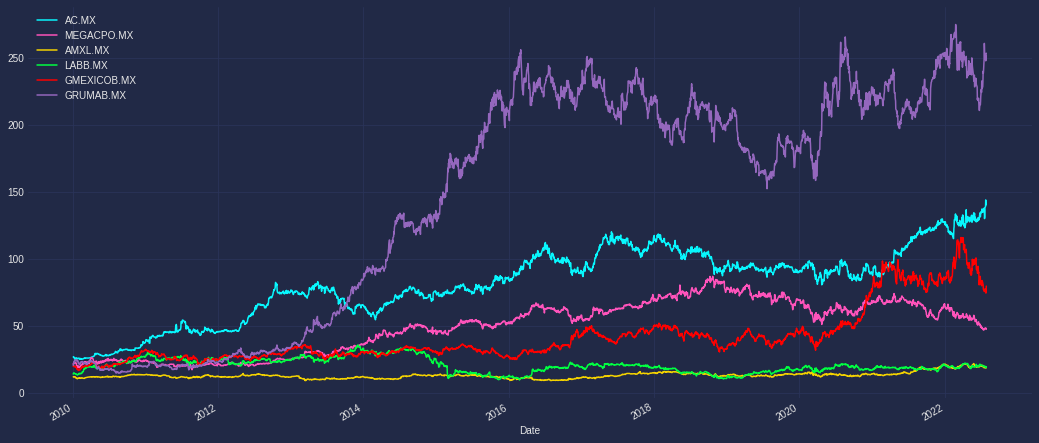

In [ ]:
data_fill.plot(figsize=(18,8))
plt.show()

In [ ]:
date_bottons = [
    {'count':1, 'label':"1M", 'step':"month", 'stepmode':"backward"},
    {'count':6, 'label':"6M", 'step':"month", 'stepmode':"backward"},
    {'count':1, 'label':"1YR", 'step':"year", 'stepmode':"backward"},
    {'count':5, 'label':"5YR", 'step':"year", 'stepmode':"backward"},
    {'step':"all"}
    ]

fig = go.Figure()
for stock in data_fill.columns:
  fig.add_trace(go.Scatter(
      x = data_fill.reset_index()['Date'],
      y = data_fill.reset_index()[stock],
      mode = 'lines',
      #fill='tozeroy',
      #line_color='blue',
      name = stock))

fig.update_layout(
    {'title': {'text': 'Precios de cierre',
               'x' : 0.5, 'y': 0.9}},
    width=1200,
    height=600
)
# time bottons
fig.update_layout(
    {'xaxis': {'rangeselector': 
               {'buttons': date_bottons}
    }}
)
fig.show()

# **Rendimientos**

In [ ]:
# Función para obtener los rendimientos 
def getReturns(data, simple=False):
  if simple:
    ret = data/data.shift(1) -1
  else:
    ret = np.log(data/data.shift(1))
  return ret.dropna()

In [ ]:
returns = getReturns(data_fill, simple=False)
returns.head()

AC.MX  MEGACPO.MX   AMXL.MX   LABB.MX  GMEXICOB.MX  GRUMAB.MX
Date                                                                        
2010-01-05  0.000000    0.034734 -0.007340  0.029872    -0.003833   0.007952
2010-01-06 -0.004608    0.003099 -0.002566  0.028083     0.012719   0.031188
2010-01-07  0.006675   -0.004479  0.013397  0.007663     0.005357   0.075838
2010-01-08 -0.018290    0.002070 -0.006676 -0.001528    -0.007571   0.021490
2010-01-11 -0.027237    0.004470  0.012678 -0.024142     0.004424  -0.015516

In [ ]:
returns.shape

(3156, 6)

In [ ]:
re = returns.mean(axis=0)
re

AC.MX          0.000529
MEGACPO.MX     0.000255
AMXL.MX        0.000150
LABB.MX        0.000099
GMEXICOB.MX    0.000444
GRUMAB.MX      0.000799
dtype: float64

# **Frontera Eficiente**

In [ ]:
# función para obtener rendimiento esperado y desv. estándar de los rendimientos
def getRiskReturn(returns):
  er = returns.mean()*252
  sdr = returns.std()*np.sqrt(252)
  return np.array(er), np.array(sdr)

In [ ]:
# función para obtener rendimiento y desv. estándar del portafolio
def PortfolioEval(returns, weights):
  # anual return returns * 252 day
  port_ret = np.sum(returns.mean()*weights)*252 
  port_sd =  np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
  #print('Rendimiento esperado del portafolio: ', port_ret)
  #print('Desviación estándar del portafolio: ', port_sd)

  return port_ret, port_sd

In [ ]:
# Función para obtener el portafolio de mínima varianza 
def getMinPortfolio1(returns): 
  n = returns.shape[1]   # número de assets
  # Convert to cvxopt matrices
  P = matrix(np.array(returns.cov()))  # matriz de covarianzas
  re = matrix(np.mean(returns, axis=0)) # vector de rendimientos esperados
  # matriz de ceros constantes de optimización cuadrática
  q = matrix(np.zeros((n, 1)))
  ############# Restricciones de desigualdad  ##################
  # Create constraint matrices
  G = matrix(-np.identity(n))        # wi >= 0
  # matriz de cotas
  h = matrix(np.zeros((n,1)))
  ############# Restricciones de igualdad  ##################
  # Pesos suman 1 : sum wi = 1
  A = matrix(1.0, (1, n))
  b = matrix(1.0)
  #################### Optimizador  ###################
  sol = qp(P, q, G, h, A, b)
  ############# Resultados del modelo  ######################
  w_min = sol['x']
  re_port = np.dot(w_min.T, re) 
  sd_port = np.sqrt(np.transpose(w_min) @ P @ w_min)

  return np.array(w_min), np.array(re_port), np.array(sd_port)

In [ ]:
# Función para obtener el portafolio de mínima varianza considerando un rendimiento esperado objetivo mínimo wi*rei >= reo
def getMinPortfolio2(returns, re_obj=0): 
  n = returns.shape[1]   # número de assets
  # Convert to cvxopt matrices
  P = matrix(np.array(returns.cov()))  # matriz de covarianzas
  re = matrix(np.mean(returns, axis=0)) # vector de rendimientos esperados
  # matriz de ceros constantes de optimización cuadrática
  q = matrix(np.zeros((n, 1)))
  ############# Restricciones de desigualdad  ##################
  # Create constraint matrices
  G = matrix(np.concatenate((
      -np.transpose(np.array(re)), # re*wi 
      -np.identity(n)), 0))        # wi
  # matriz de cotas
  h = matrix(np.concatenate((
              -np.ones((1,1))*re_obj, 
                np.zeros((n,1))), 0))
  ############# Restricciones de igualdad  ###################
  # Pesos suman 1 : sum wi = 1
  A = matrix(1.0, (1, n))
  b = matrix(1.0)
  ##################  Optimizador   ##########################
  sol = qp(P, q, G, h, A, b)
  ################# resultados del modelo  ###################
  w_min = sol['x']
  re_port = np.dot(w_min.T, re) 
  sd_port = np.sqrt(np.transpose(w_min) @ P @ w_min)

  return np.array(w_min), np.array(re_port), np.array(sd_port)

In [ ]:
# Función para obtener el portafolio de mínima varianza considerando un rendimiento esperado objetivo igual a cierto valor wi*rei = reo
def getMinPortfolio3(returns, re_obj): 
  n = returns.shape[1]   # número de assets
  # Convert to cvxopt matrices
  P = matrix(np.array(returns.cov()))  # matriz de covarianzas
  re = matrix(np.mean(returns, axis=0)) # vector de rendimientos esperados
  # matriz de ceros constantes de optimización cuadrática
  q = matrix(np.zeros((n, 1)))
  ############# Restricciones de desigualdad  ##################
  # Create constraint matrices
  G = matrix(-np.identity(n))        # wi >= 0
  # matriz de cotas
  h = matrix(np.zeros((n,1)))
  ############# Restricciones de igualdad  ###################
  # Pesos suman 1 : sum wi = 1
  A = matrix(np.concatenate((
      np.transpose(np.array(re)), # re*wi = re_obj
      np.transpose(np.ones((n,1)))), 0))  # sum wi = 1
  b = matrix(np.concatenate((
      np.ones((1,1))*re_obj, 
      np.ones((1,1))), 0))
  ##################  Optimizador   ##########################
  sol = qp(P, q, G, h, A, b)
  ################# resultados del modelo  ###################
  w_min = sol['x']
  re_port = np.dot(w_min.T, re)
  sd_port = np.sqrt(np.transpose(w_min) @ P @ w_min)

  return np.array(w_min), np.array(re_port), np.array(sd_port)

In [ ]:
# función para gráficar la fontera eficiente
def EfficientFrontier(returns, nport=50):
  n = returns.shape[1]   # número de assets
  # Convert to cvxopt matrices
  P = matrix(np.array(returns.cov()))  # matriz de covarianzas
  re = matrix(np.mean(returns, axis=0)) # vector de rendimientos esperados
  # matriz de ceros constantes de optimización cuadrática
  q = matrix(np.zeros((n, 1)))
  # obtención del mínimo
  w_min, re_port_min, sd_port_min = getMinPortfolio1(returns)
  # n portafolios entre re_port_min y max re
  n_re = np.linspace(re_port_min, np.max(re), nport)
  # ciclo
  w_n = []  # lista de pesos
  re_n = []
  sd_n = []
  for reo in n_re:
    w_min, re_port_min, sd_port_min = getMinPortfolio3(returns, re_obj=reo)
    w_n.append(w_min)
    re_n.append(re_port_min.flatten())
    sd_n.append(sd_port_min.flatten())
    
  return np.array(w_n), np.array(re_n), np.array(sd_n), -np.array(re_n) + re_port_min

In [ ]:
w_n, re_n_sup, sd_n, re_n_inf = EfficientFrontier(returns, nport=50)

     pcost       dcost       gap    pres   dres
 0:  4.7934e-05 -9.9999e-01  1e+00  2e-16  3e+00
 1:  4.7932e-05 -9.9856e-03  1e-02  2e-16  3e-02
 2:  4.7799e-05 -8.5335e-05  1e-04  2e-16  4e-04
 3:  4.3531e-05  2.5135e-05  2e-05  7e-17  5e-05
 4:  4.1042e-05  3.9333e-05  2e-06  9e-17  3e-08
 5:  4.0895e-05  4.0810e-05  8e-08  1e-16  3e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.7471e-05 -1.0249e+00  1e+00  2e-16  3e+00
 1:  4.7470e-05 -1.0232e-02  1e-02  2e-16  3e-02
 2:  4.7360e-05 -8.5121e-05  1e-04  1e-16  4e-04
 3:  4.3392e-05  2.6495e-05  2e-05  9e-17  4e-05
 4:  4.1022e-05  3.9458e-05  2e-06  9e-17  4e-20
 5:  4.0895e-05  4.0820e-05  7e-08  1e-16  2e-20
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.7403e-05 -1.0335e+00  1e+00  2e-16  3e+00
 1:  4.7402e-05 -1.0318e-02  1e-02  7e-17  3e-02
 2:  4.7295e-05 -8.6462e-05  1e-04  1e-16  4e-04
 3:  4.3402e-05  2.6326e-05  2e-05  1e-16  4e-05
 4:  4.1047e-05  3.9502e

In [ ]:
# función para generar n portafolios (nport) con pesos aleatorios. 
def getRandomPortfolios(returns, nport=100):
  portfolio_means = []
  portfolio_risks = []
  portfolio_weights = []

  for i in range(nport):
    w = np.random.rand(len(returns.columns)).round(4)
    w /= np.sum(w)
    portfolio_weights.append(w)
    portfolio_means.append(np.sum(returns.mean() * w) * 252)
    portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()* 252, w))))

  return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)


In [ ]:
mean_stocks, risk_stocks = getRiskReturn(returns)
pweights, means, risk = getRandomPortfolios(returns, nport=80000)


In [ ]:
# función definida para el optimizador calcula el rp, la sdp y rp/sdp, para todos los pesos generados
def SampleData(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()* 252, weights)))
    return np.array([portfolio_return, portfolio_volatility,
                     portfolio_return / portfolio_volatility])

## **Portafolio Máxima Razón de Sharpe**

\begin{eqnarray}
 maximizar             & \ Sharpe Ratio = \left(\mathop \sum \limits_{i = 1}^n w_i^2\sigma _i^2\right)  /  \left(\mathop \sum \limits_{i = 1}^n w_i^2\sigma _i^2 + 2\mathop \sum \limits_{i = 1}^n \mathop \sum \limits_{j = i + 1}^n {w_i}{w_j}{\sigma _{ij}} \right)^{1/2}\\
 sujeto\ a             & w_1 + w_2 + \ldots + w_n = 1 \\
                       & w_i \geq 0
\end{eqnarray}

In [ ]:
# función a maximizar (por defecto minimiza)
def SharpeRatio(weights, returns):
    return -SampleData(weights, returns)[2]

Referencia sobre el optimizador:

[scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/tutorial/optimize.html)

In [ ]:
# optimizador
def maxSharpeRatioPorfolio(weights, returns):
    # la suma de wi = 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # wi >= 0: 1 cuando se invierte todo en un simple activo
    bounds = tuple((0, 1) for i in range(len(returns.columns)))
    # optimizador
    result = optimize.minimize(fun=SharpeRatio, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [ ]:
optimum = maxSharpeRatioPorfolio(pweights, returns)
optimum

     fun: -0.9001527250613708
     jac: array([-0.00028635, -0.00117072,  0.1310856 ,  0.22769693,  0.00063093,
        0.00040611])
 message: 'Optimization terminated successfully'
    nfev: 51
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([4.51760221e-01, 7.02197609e-02, 2.55126324e-17, 0.00000000e+00,
       7.22465815e-02, 4.05773437e-01])

## **Portafolio de Mínima Varianza**

\begin{eqnarray}
 minimizar             & \ \ \sigma_p^2 = \mathop \sum \limits_{i = 1}^n w_i^2\sigma _i^2 + 2\mathop \sum \limits_{i = 1}^n \mathop \sum \limits_{j = i + 1}^n {w_i}{w_j}{\sigma _{ij}}\\
 sujeto\ a             & w_1 + w_2 + \ldots + w_n = 1 \\
                       & w_i \geq 0
\end{eqnarray}

In [ ]:
def StandarDeviation(weights, returns):
    return SampleData(weights, returns)[1]

In [ ]:
def minStandarDeviation(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0, 1) for _ in range(len(returns.columns)))
    return optimize.minimize(fun=StandarDeviation, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)

In [ ]:
optimum2 = minStandarDeviation(pweights, ret)
optimum2

     fun: 0.14356220875187142
     jac: array([0.1432616 , 0.14396711, 0.14345815, 0.14434434, 0.14356606,
       0.14342277])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.32593447, 0.21489312, 0.20021859, 0.06557595, 0.04869732,
       0.14468055])

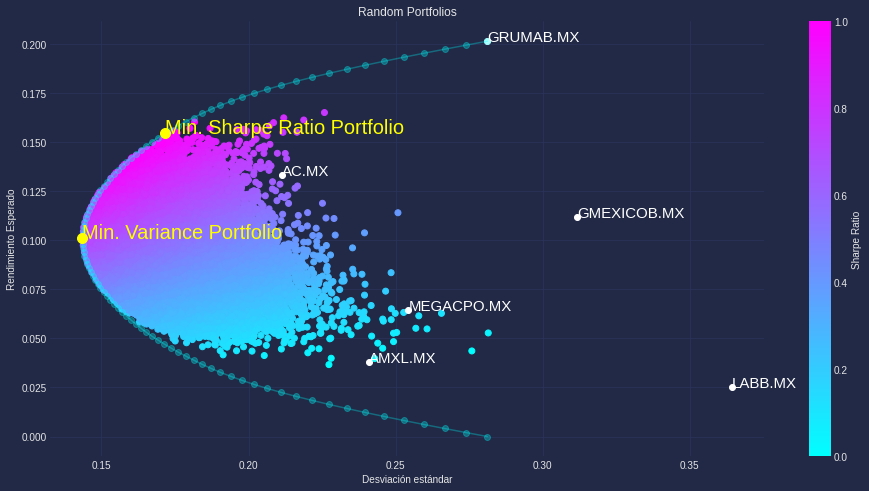

In [ ]:
plt.figure(figsize=(16, 8))
plt.scatter(risk, means, c=means/risk, marker='o')
######################################## Forntera eficiente
plt.plot(sd_n*np.sqrt(252), re_n_sup*252, 'o', c='cyan', alpha=0.3)
plt.plot(sd_n*np.sqrt(252), re_n_sup*252, '-', c='cyan', alpha=0.3)
plt.plot(sd_n*np.sqrt(252), re_n_inf*252, 'o', c='cyan', alpha=0.3)
plt.plot(sd_n*np.sqrt(252), re_n_inf*252, '-', c='cyan', alpha=0.3)
######################################## Min sharpe ratio
plt.plot(SampleData(optimum['x'], ret)[1], SampleData(optimum['x'], ret)[0], marker='o', c='yellow', markersize=10.0)
plt.text(SampleData(optimum['x'], ret)[1], SampleData(optimum['x'], ret)[0],'Min. Sharpe Ratio Portfolio', c='yellow', size=20)
######################################## Min variance
plt.plot(SampleData(optimum2['x'], ret)[1], SampleData(optimum2['x'], ret)[0], marker='o', c='yellow', markersize=10.0)
plt.text(SampleData(optimum2['x'], ret)[1], SampleData(optimum2['x'], ret)[0],'Min. Variance Portfolio', c='yellow', size=20)
# stocks
plt.scatter(risk_stocks, mean_stocks, c='white', marker='o')
for i in range(len(stocks2)):
  plt.text(risk_stocks[i], mean_stocks[i], stocks2[i], fontsize = 15, color = 'white')
#plt.scatter(risk_stocks, mean_stocks, c='blue', marker='o')
plt.grid(True)
plt.xlabel('Desviación estándar')
plt.ylabel('Rendimiento Esperado')
plt.colorbar(label='Sharpe Ratio')
plt.title('Random Portfolios')
plt.show()

In [ ]:
fig = go.Figure()

# frontera eficiente
fig.add_trace(go.Scatter(
    x=sd_n.flatten()*np.sqrt(252),
    y=re_n_sup.flatten()*252,
    marker={'color':'green',
            'size': 4},
    mode="markers"))

fig.add_trace(go.Scatter(
    x=sd_n.flatten()*np.sqrt(252),
    y=re_n_inf.flatten()*252,
    marker={'color':'blue',
            'size': 4},
    mode="markers"))

# random portfolios
fig.add_trace(go.Scatter(
    x=risk,
    y=means,
    marker=dict(
        size=5,
        cmax=1,
        cmin=0,
        color=means/risk,
        colorbar=dict(
            title="Sharpe Ratio"
        ),
        colorscale="Viridis"
    ),
    mode="markers"))
# stocks
fig.add_trace(go.Scatter(
    x=risk_stocks,
    y=mean_stocks,
    text=stocks2,
    marker=dict(
        size=10,
        cmax=3,
        cmin=0,
        color='orange'),
    mode="markers+text",
    textposition="bottom center"))
# min sharpe ration
fig.add_trace(go.Scatter(
    x=[SampleData(optimum['x'], ret)[1]],
    y=[SampleData(optimum['x'], ret)[0]],
    text="Max. Sharpe Ratio Portfolio",
    marker=dict(
        size=10,
        color='red'),
    mode="markers+text",
    textposition="bottom center"))

# min variance
fig.add_trace(go.Scatter(
    x=[SampleData(optimum2['x'], ret)[1]],
    y=[SampleData(optimum2['x'], ret)[0]],
    text="Min. Variance Portfolio",
    marker=dict(
        size=10,
        color='red'),
    mode="markers+text",
    textposition="bottom center"))


fig.update_layout(
    {'title': {'text': 'Frontera eficiente',
               'x' : 0.5, 'y': 0.9}},
    width=1200,
    height=700,
    showlegend=False
)

fig.show()

# **Rendimientos acumulados**

In [ ]:
ret.head()

AC.MX  MEGACPO.MX   AMXL.MX   LABB.MX  GMEXICOB.MX  GRUMAB.MX
Date                                                                        
2010-01-05  0.000000    0.034734 -0.007340  0.029872    -0.003832   0.007952
2010-01-06 -0.004609    0.003099 -0.002566  0.028083     0.012719   0.031188
2010-01-07  0.006675   -0.004479  0.013398  0.007663     0.005357   0.075838
2010-01-08 -0.018290    0.002070 -0.006676 -0.001528    -0.007571   0.021490
2010-01-11 -0.027237    0.004470  0.012679 -0.024142     0.004423  -0.015516

In [ ]:
cum_ret_min_sr = np.dot(ret,optimum['x']).cumsum()
cum_ret_min_var = np.dot(ret,optimum2['x']).cumsum()

In [ ]:
df_cum_ret = pd.DataFrame({'cum_ret_min_sr': cum_ret_min_sr, 
                           'cum_ret_min_var': cum_ret_min_var})

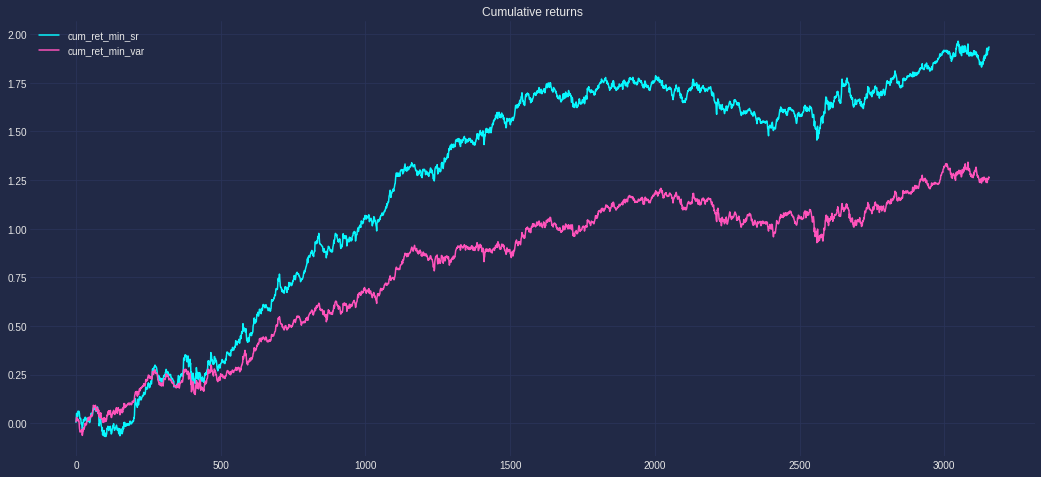

In [ ]:
df_cum_ret.plot(figsize=(18,8))
plt.title('Cumulative returns')
plt.show()